##Import the Libararies

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt

##Loading the data


In [3]:
from google.colab import drive
import shutil
import zipfile

drive.mount('/content/drive')
zip_file_path = '/content/drive/My Drive/VIT/0Scope/DL/archive.zip'
shutil.copy(zip_file_path, '/content/archive.zip')
zip_file_name = '/content/archive.zip'

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/')


Mounted at /content/drive


##Exploratory Data Analysis

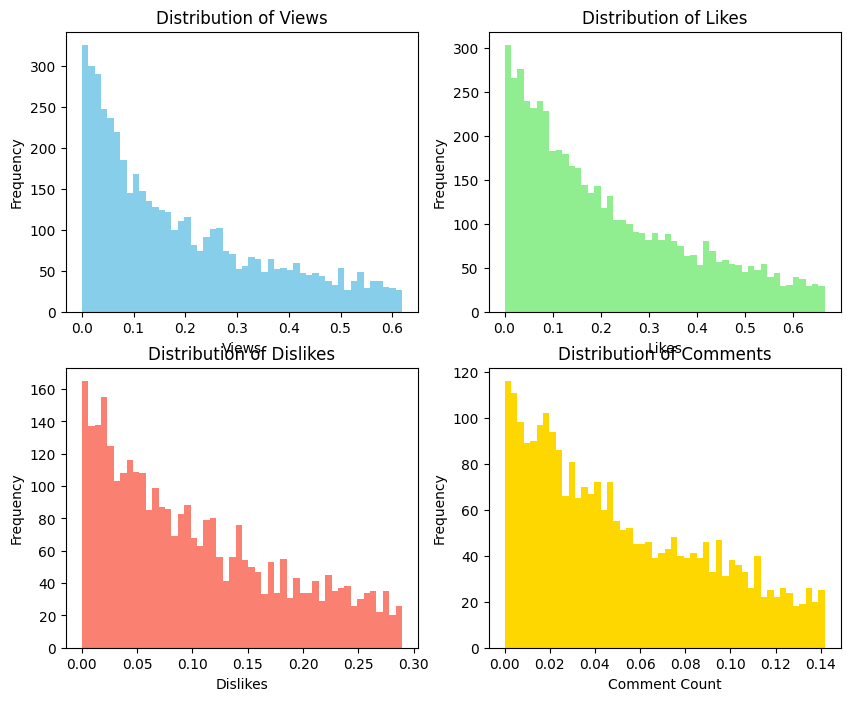

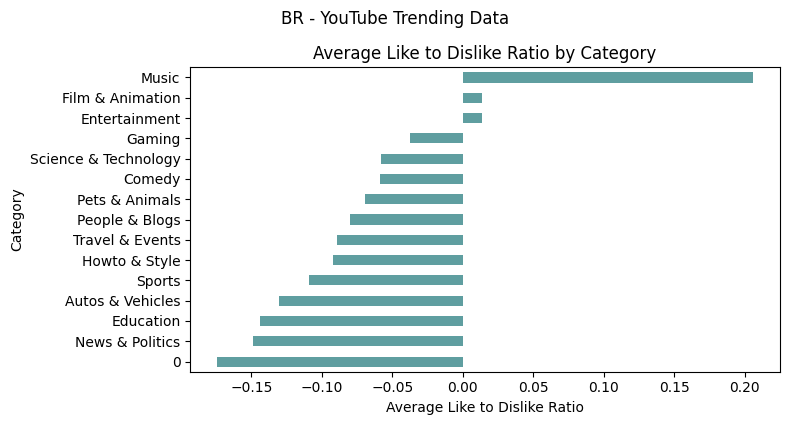

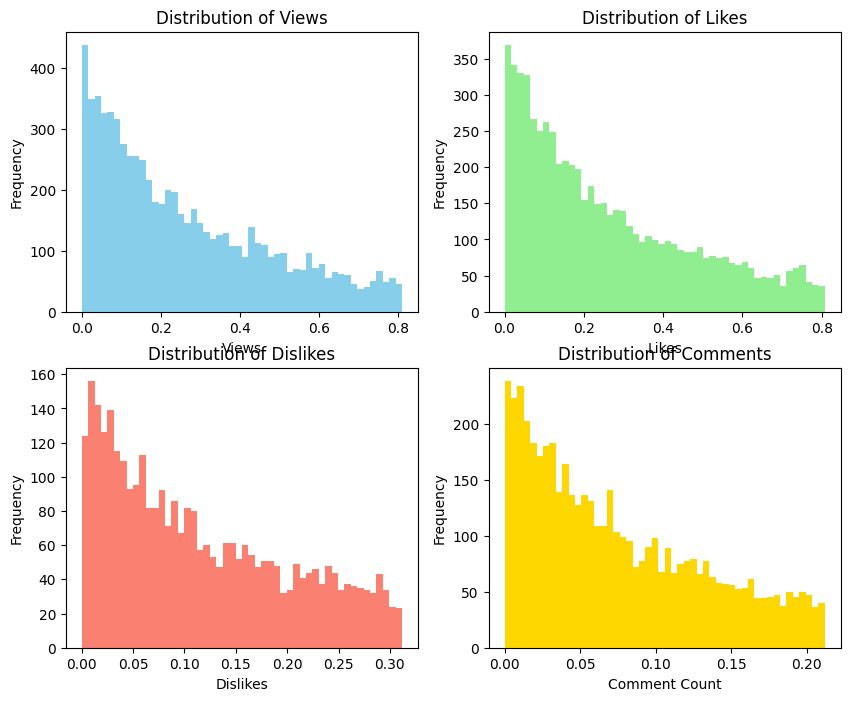

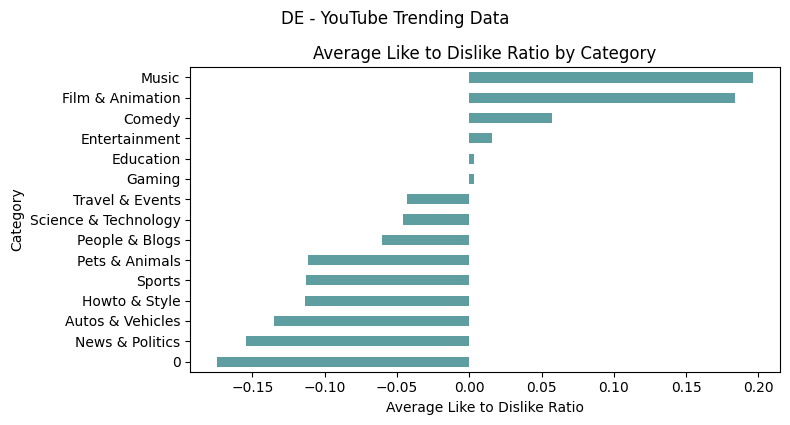

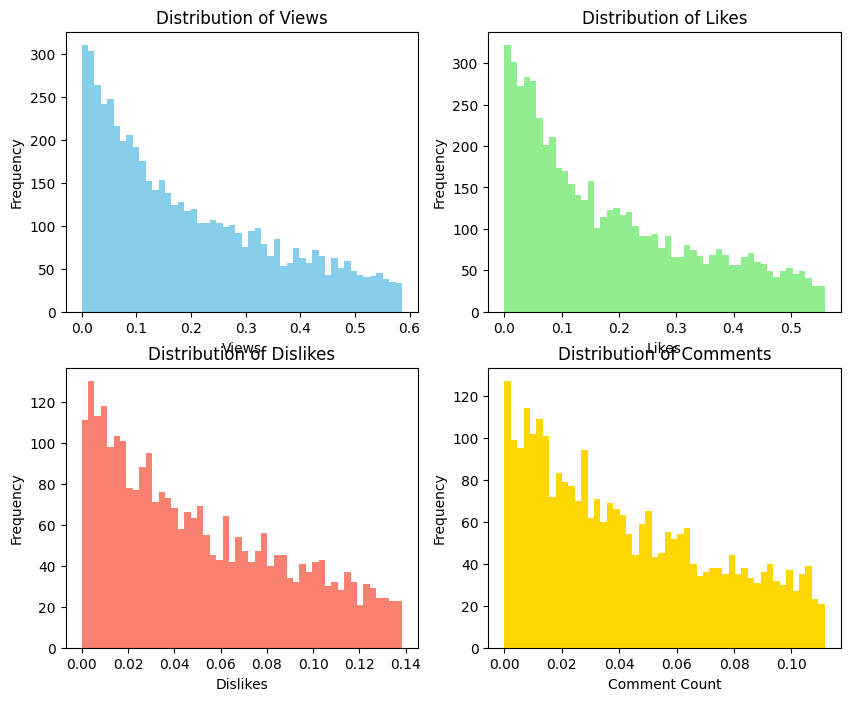

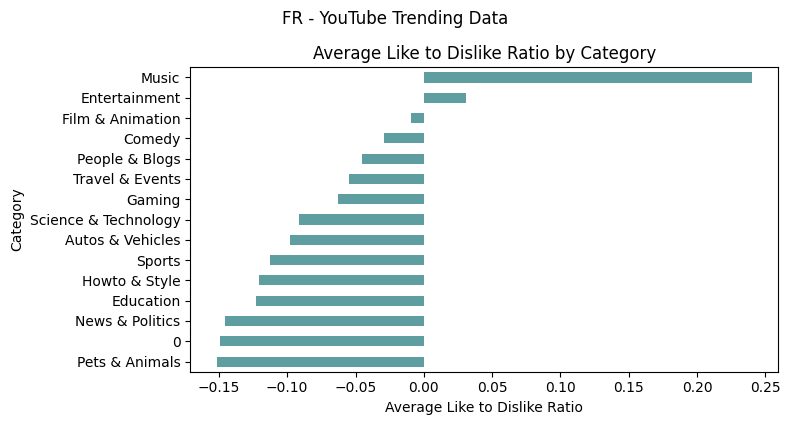

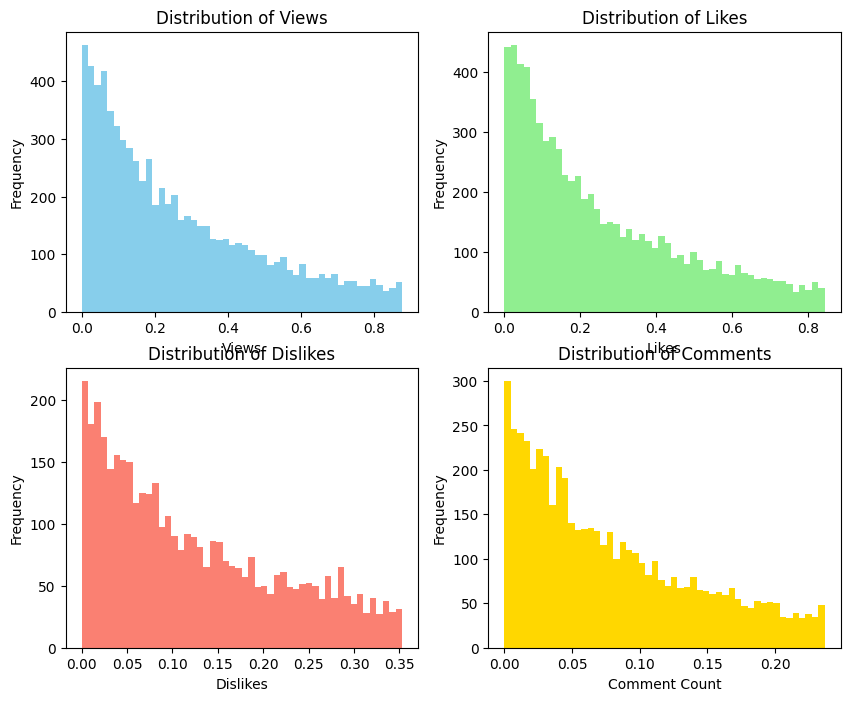

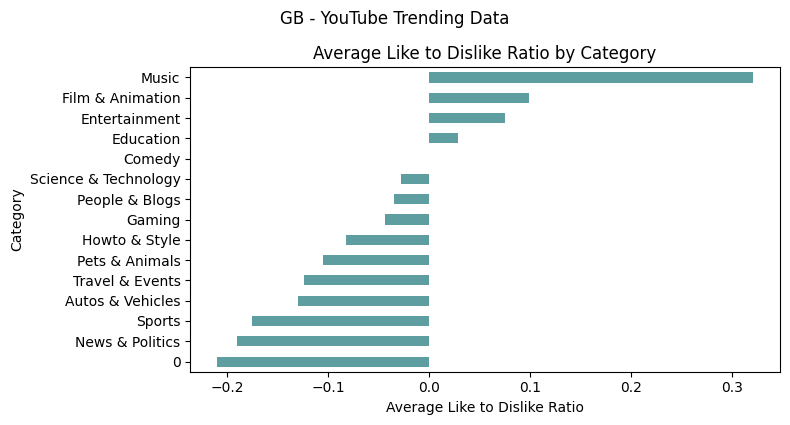

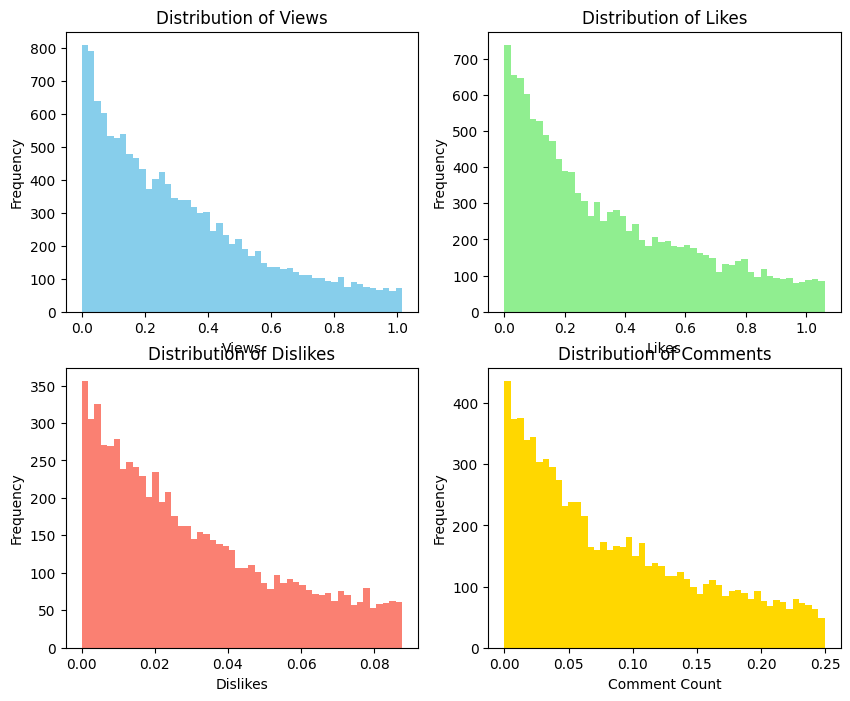

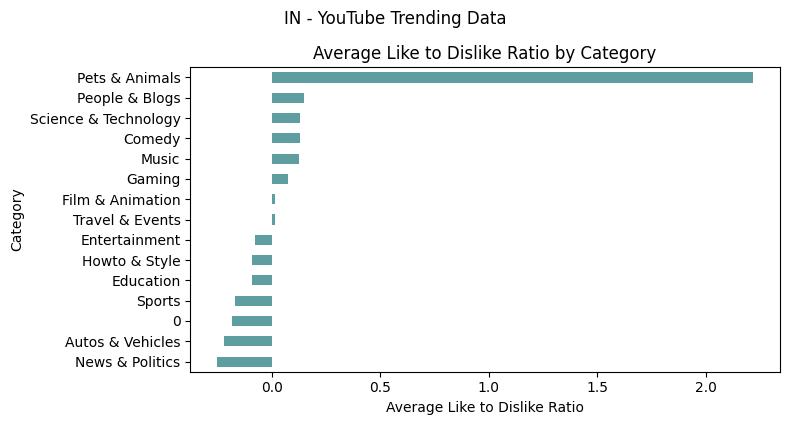

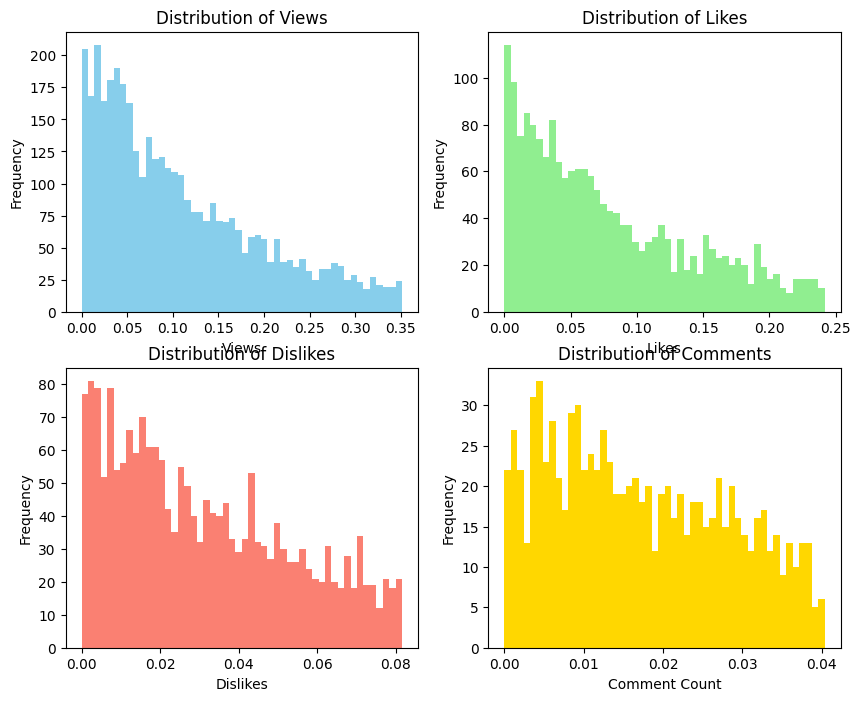

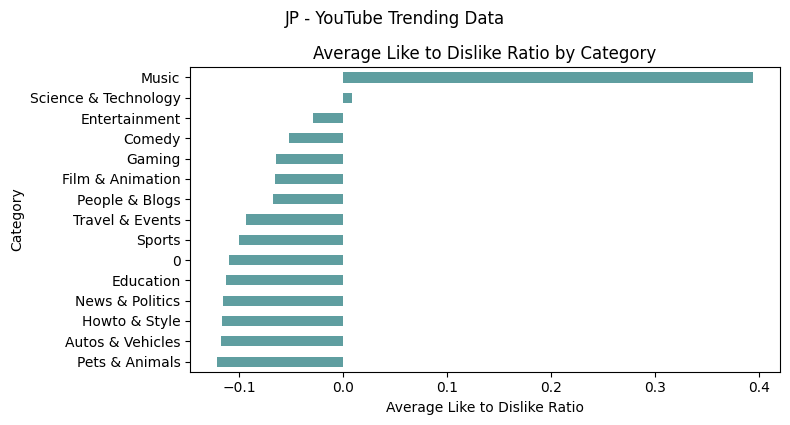

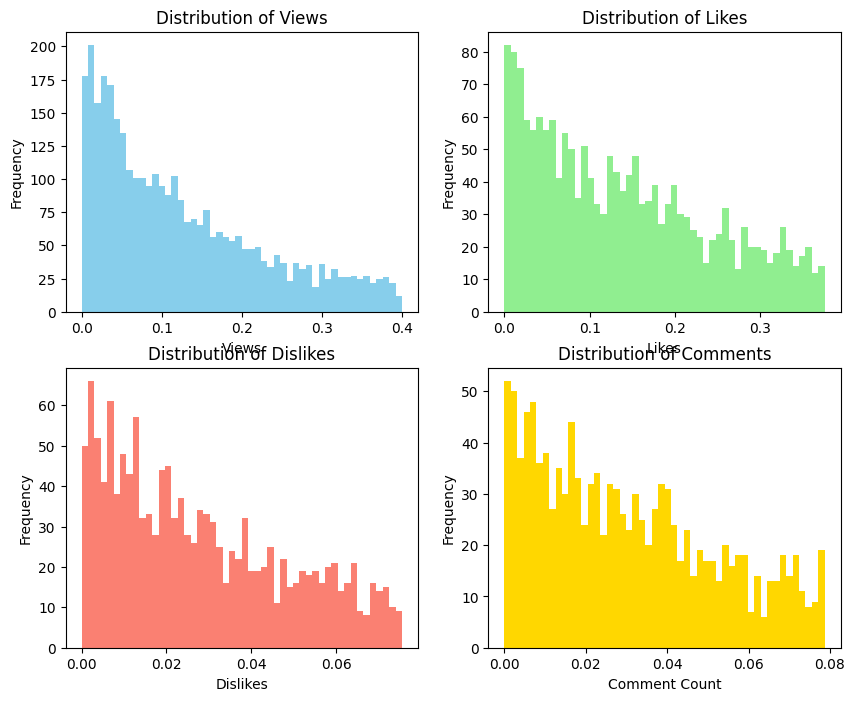

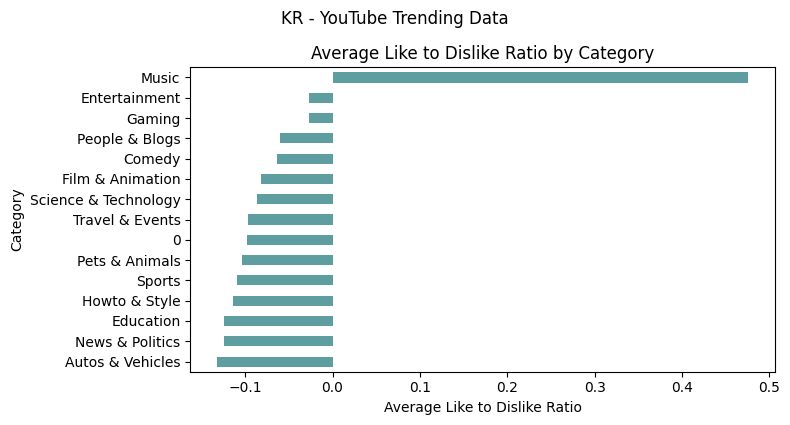

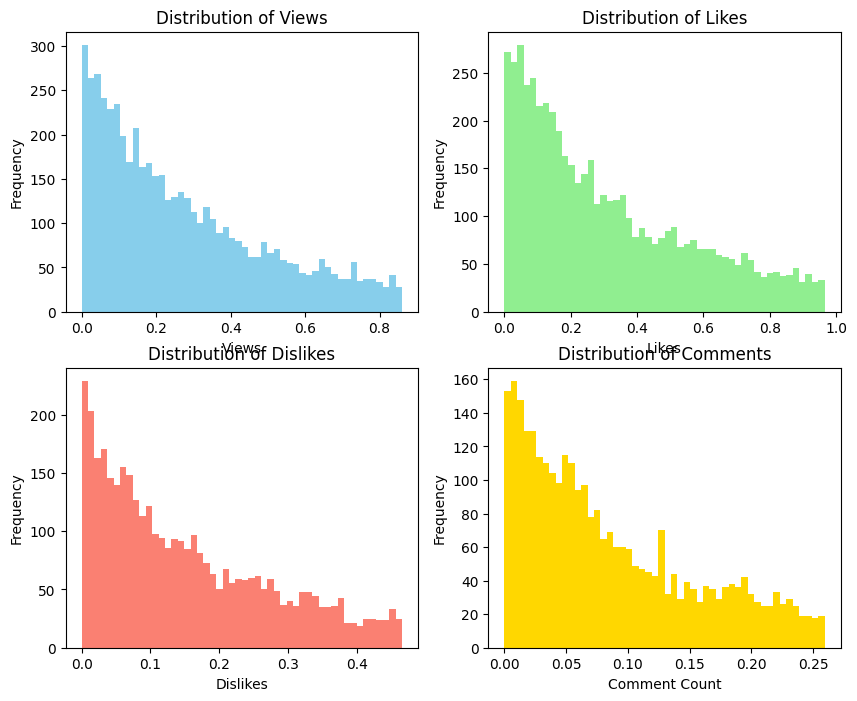

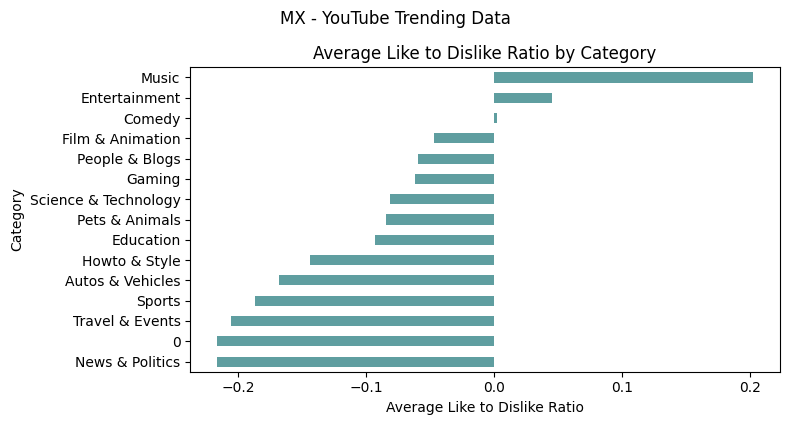

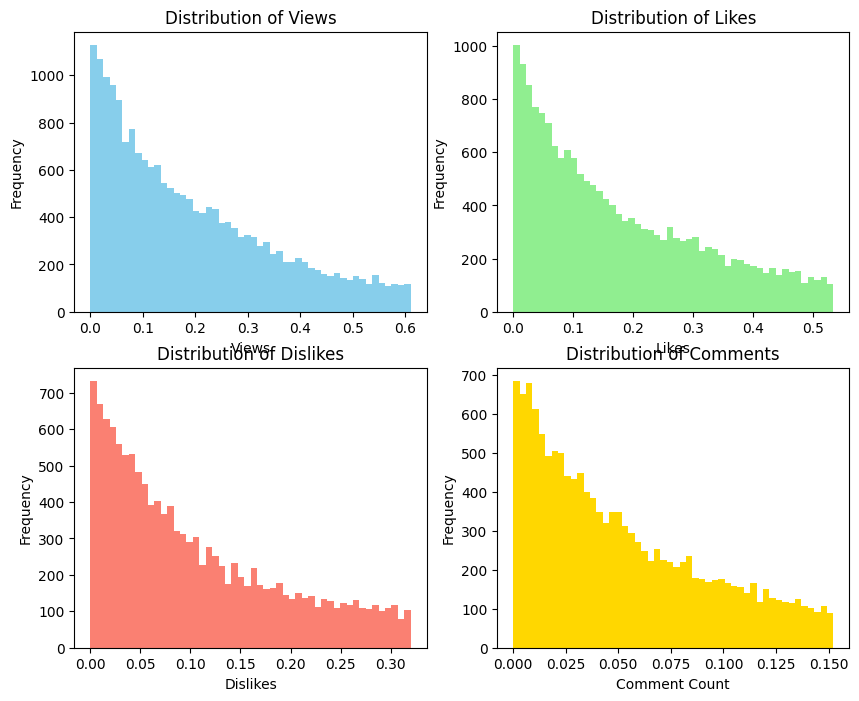

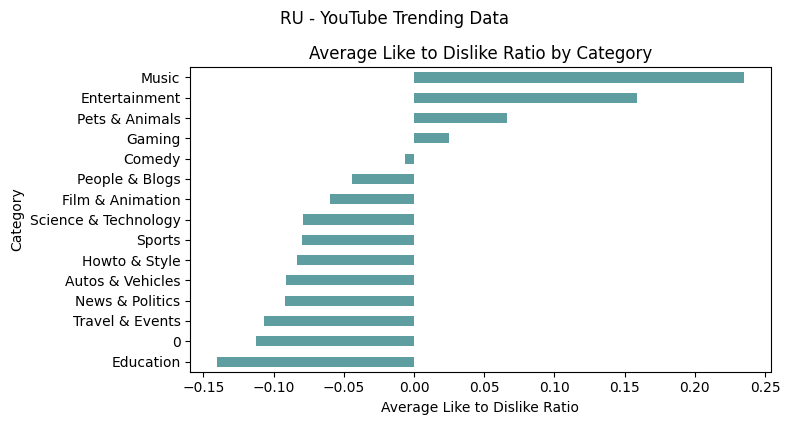

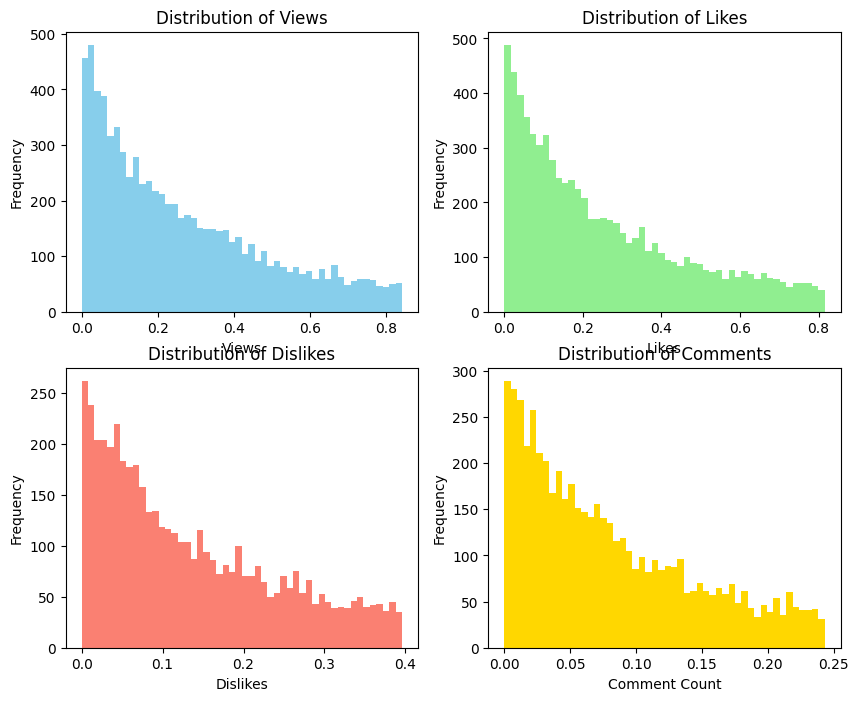

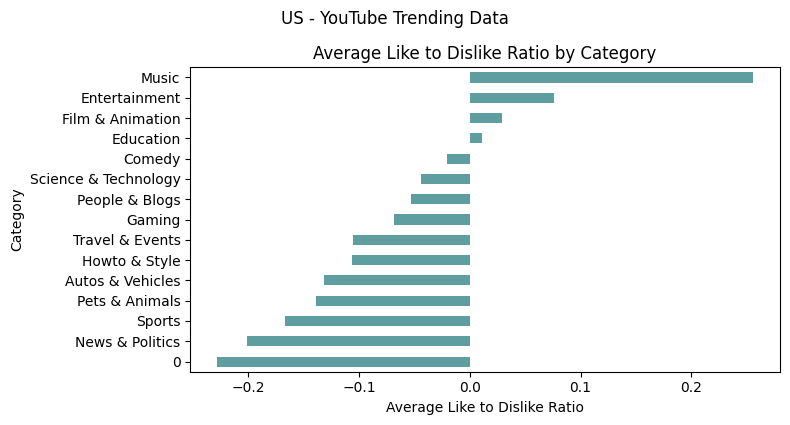

In [5]:
# List of countries
countries = ['BR', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US']

# Load category data
categories = pd.read_json('IN_category_id.json')
categories_dict = {}
for index, row in categories.iterrows():
    item = row['items']
    category_id = int(item['id'])
    category_title = item['snippet']['title']
    categories_dict[category_id] = category_title

# Loop over countries
for country in countries:
    # Load YouTube trending data for the country
    video_data = pd.read_csv(f'{country}_youtube_trending_data.csv')

    # Map category IDs to category names
    video_data['category_name'] = video_data['categoryId'].map(categories_dict)

    # Convert trending_date to datetime format
    video_data['trending_date'] = pd.to_datetime(video_data['trending_date'], format='%Y-%m-%dT%H:%M:%SZ')

    # Fill missing values with 0
    video_data.fillna(0, inplace=True)

    # Drop duplicate videos, keeping the last entry
    video_data.drop_duplicates(subset='video_id', keep='last', inplace=True)

    # Calculate ratios
    video_data['like_to_dislike_ratio'] = video_data['likes'] / (video_data['dislikes'] + 1)
    video_data['like_to_view_ratio'] = video_data['likes'] / (video_data['view_count'] + 1)
    video_data['comment_to_view_ratio'] = video_data['comment_count'] / (video_data['view_count'] + 1)

    # Standardize numerical features
    scaler = StandardScaler()
    numerical_features = ['view_count', 'likes', 'dislikes', 'comment_count',
                          'like_to_dislike_ratio', 'like_to_view_ratio', 'comment_to_view_ratio']
    video_data[numerical_features] = scaler.fit_transform(video_data[numerical_features])

    # Set quantile values
    view_count_95th = video_data['view_count'].quantile(0.95)
    likes_95th = video_data['likes'].quantile(0.95)
    dislikes_95th = video_data['dislikes'].quantile(0.95)
    comment_count_95th = video_data['comment_count'].quantile(0.95)

    # Plot histograms
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    plt.hist(video_data['view_count'], bins=50, color='skyblue', range=[0, view_count_95th])
    plt.title('Distribution of Views')
    plt.xlabel('Views')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 2)
    plt.hist(video_data['likes'], bins=50, color='lightgreen', range=[0, likes_95th])
    plt.title('Distribution of Likes')
    plt.xlabel('Likes')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 3)
    plt.hist(video_data['dislikes'], bins=50, color='salmon', range=[0, dislikes_95th])
    plt.title('Distribution of Dislikes')
    plt.xlabel('Dislikes')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 4)
    plt.hist(video_data['comment_count'], bins=50, color='gold', range=[0, comment_count_95th])
    plt.title('Distribution of Comments')
    plt.xlabel('Comment Count')
    plt.ylabel('Frequency')

    avg_ld_ratio_by_cat = video_data.groupby('category_name')['like_to_dislike_ratio'].mean().sort_values()

    plt.figure(figsize=(8, 4))
    avg_ld_ratio_by_cat.plot(kind='barh', color='cadetblue')
    plt.title('Average Like to Dislike Ratio by Category')
    plt.xlabel('Average Like to Dislike Ratio')  # x-axis title
    plt.ylabel('Category')  # y-axis title

    plt.tight_layout()
    plt.suptitle(f'{country} - YouTube Trending Data', y=1.05)  # Title for the entire figure
    plt.show()


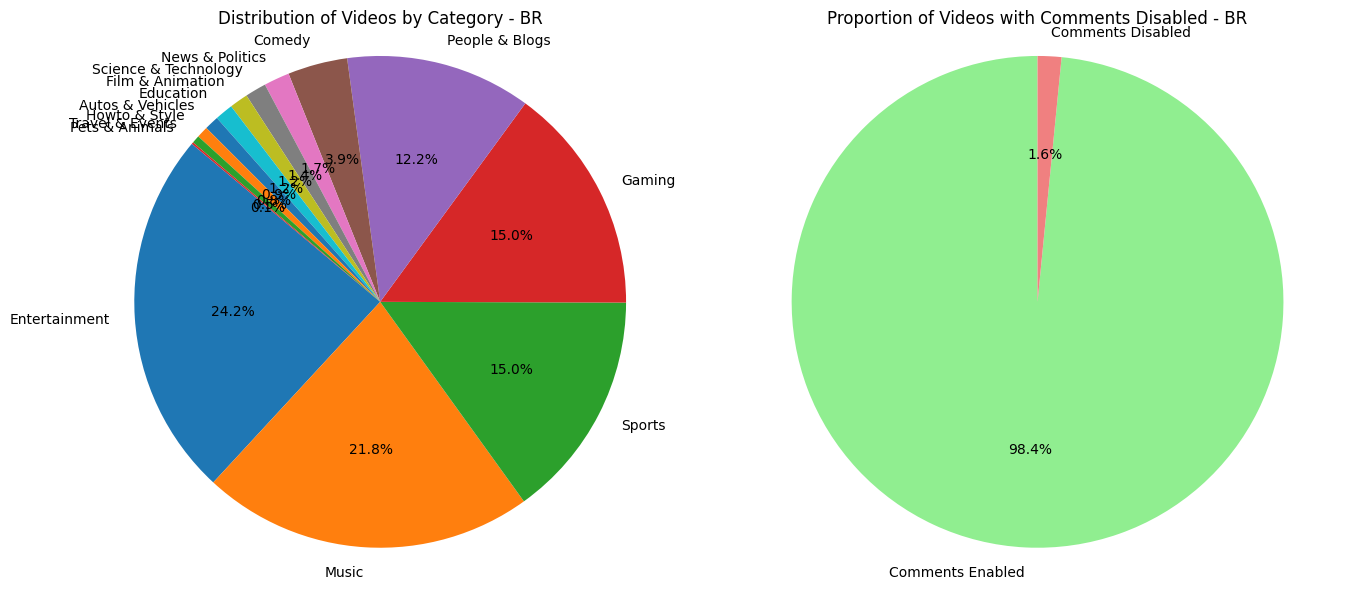

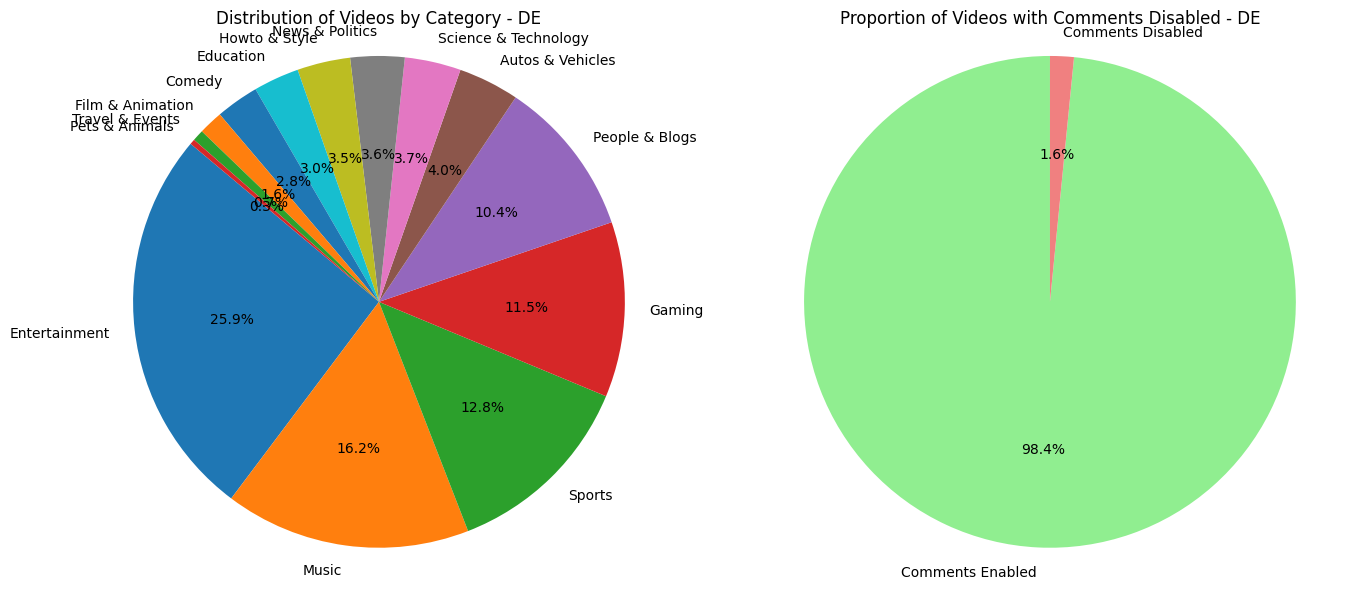

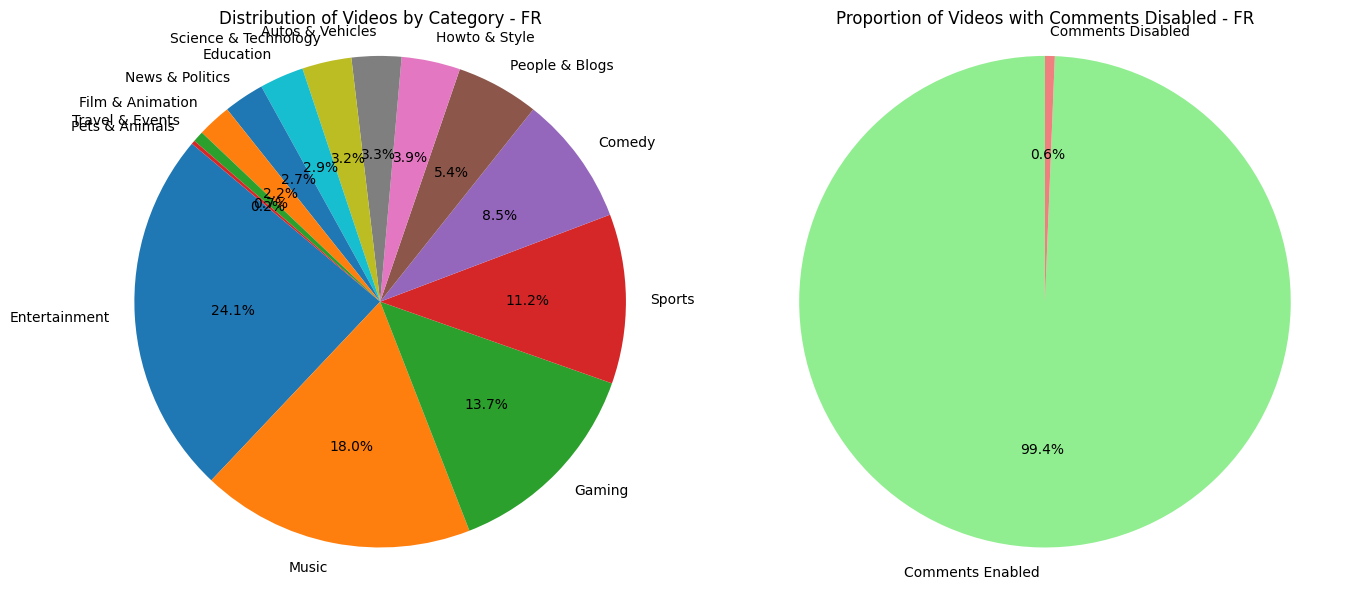

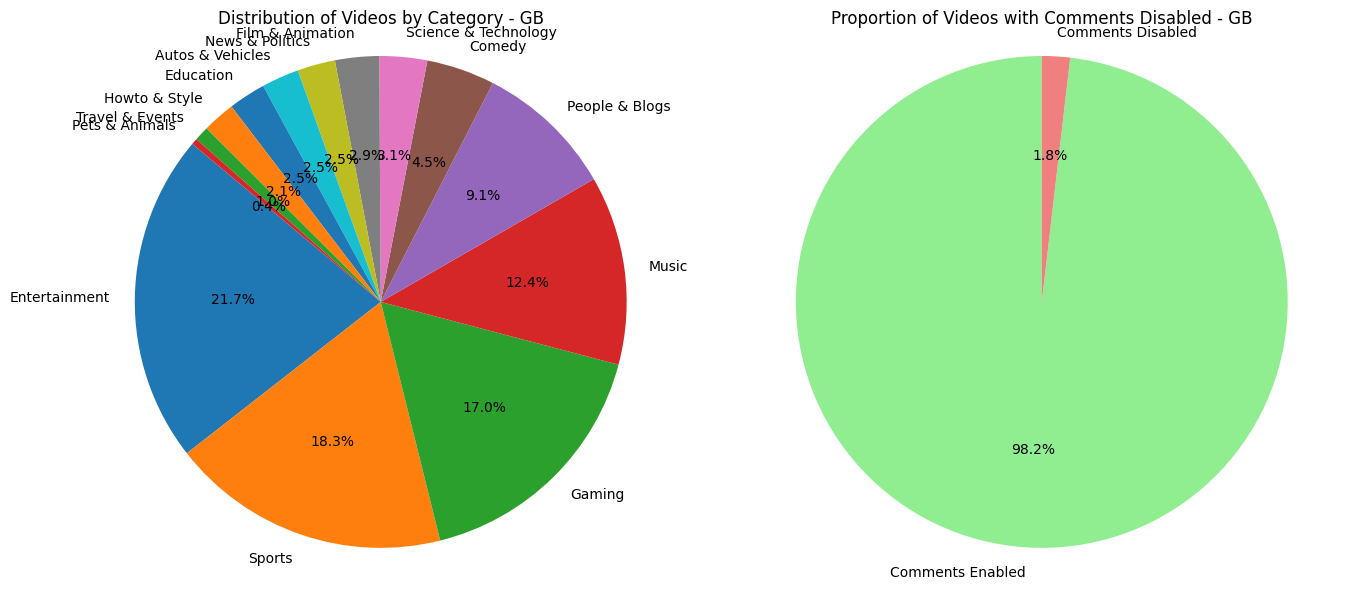

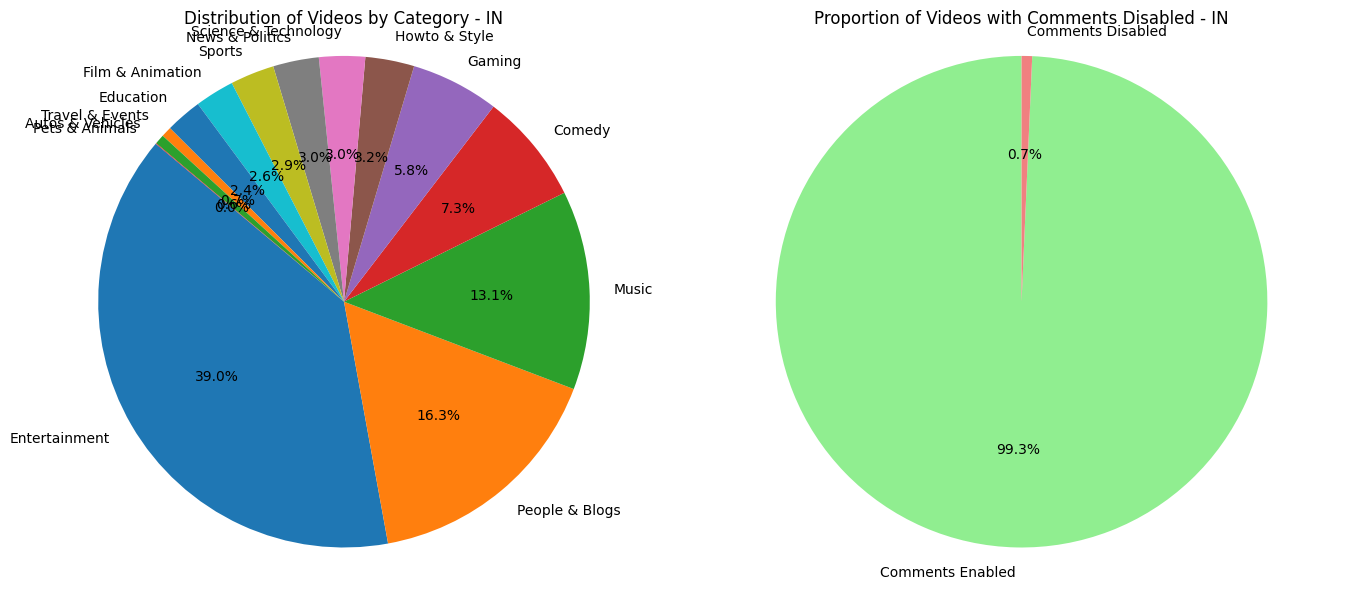

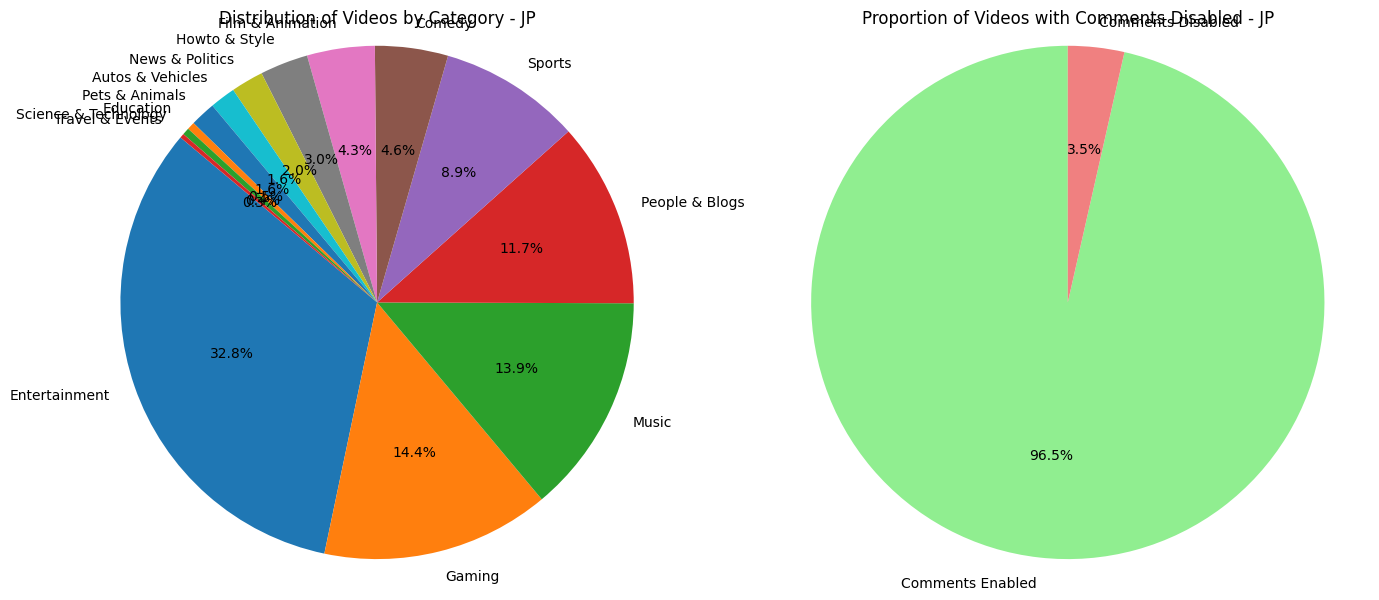

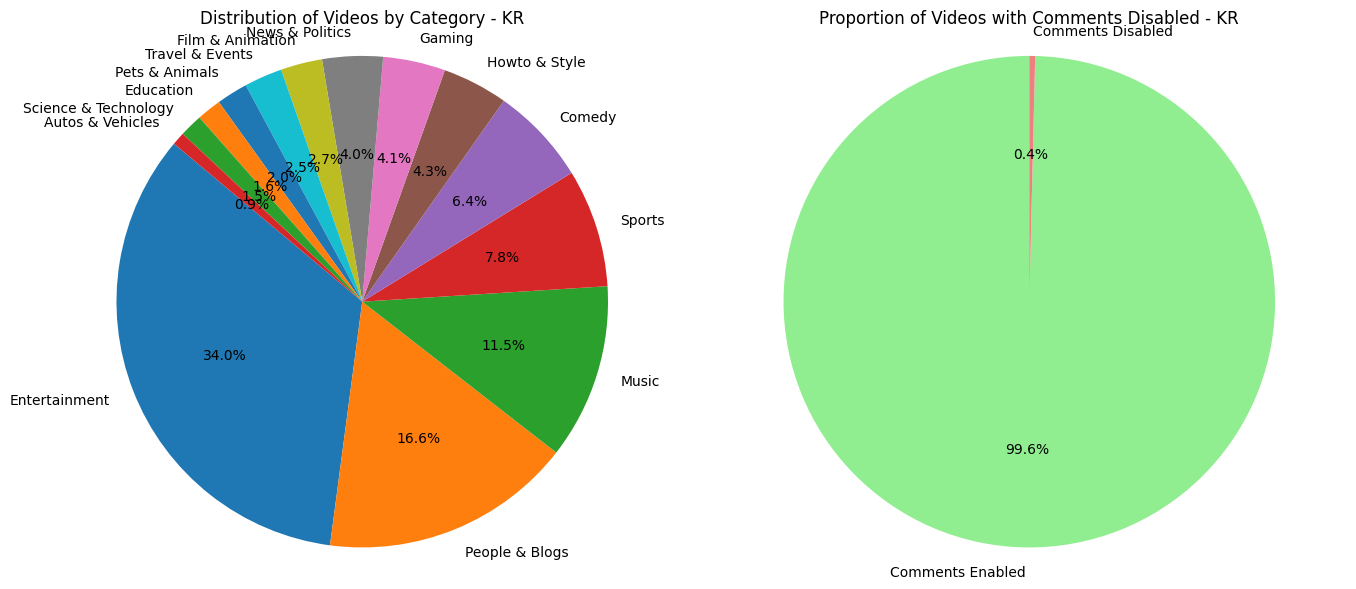

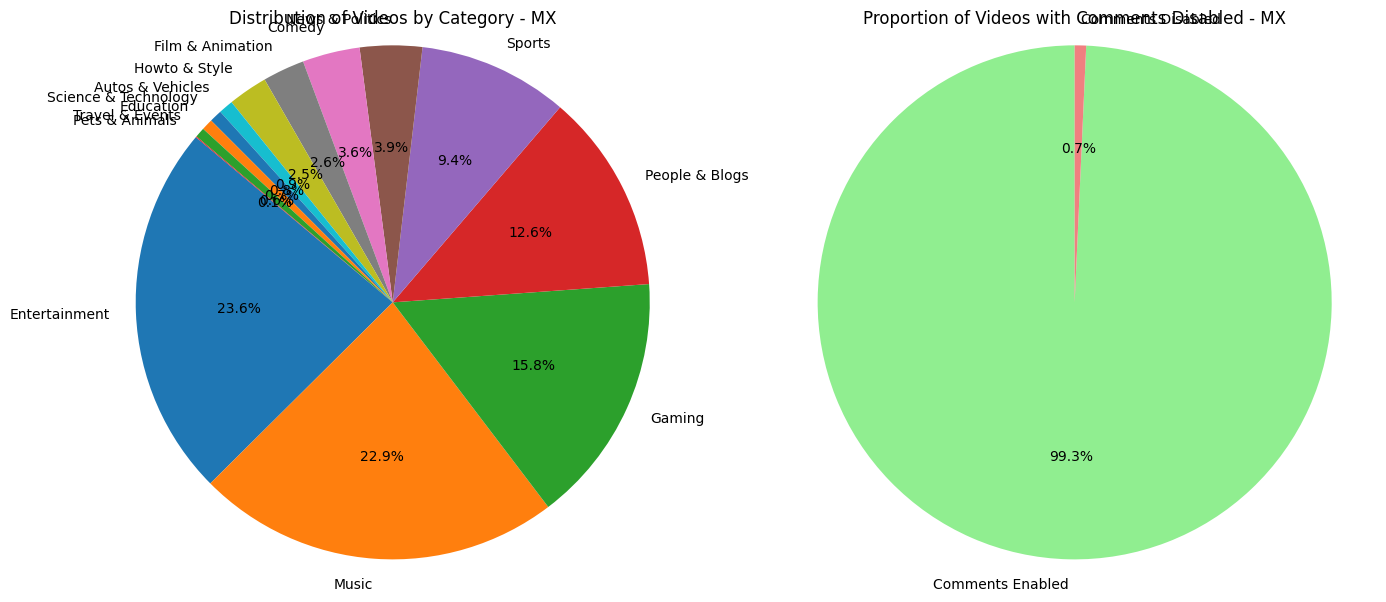

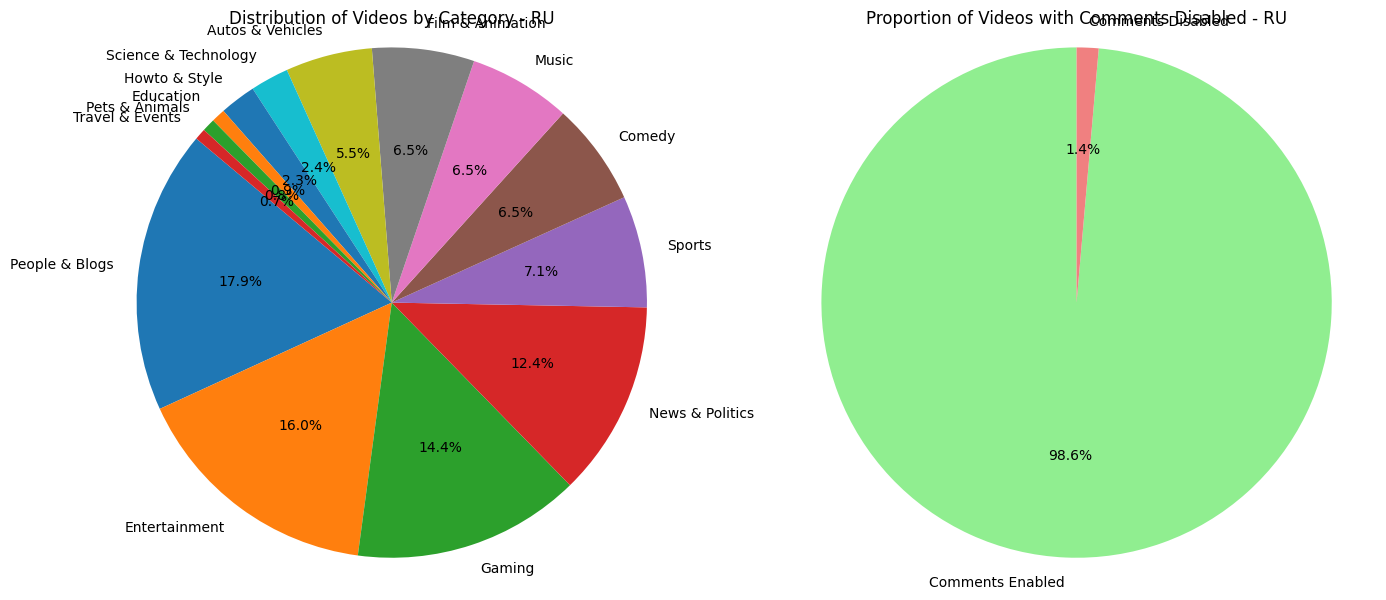

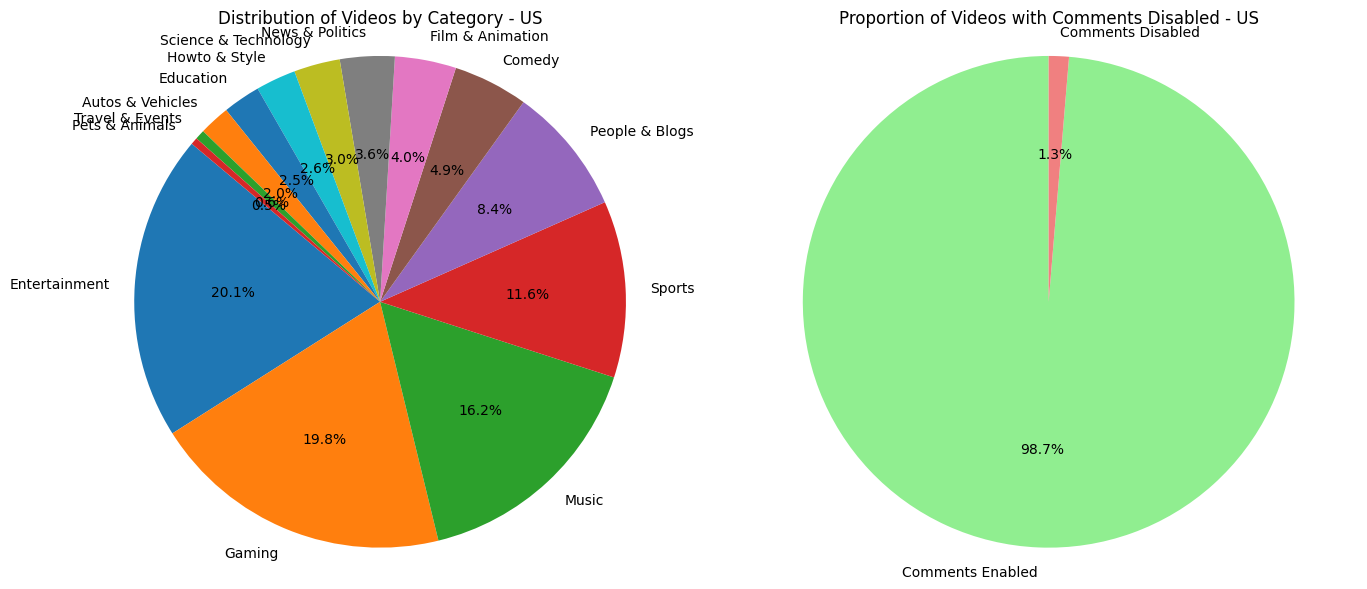

In [60]:
countries = ['BR', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US']

# Load category data
categories = pd.read_json('IN_category_id.json')
categories_dict = {}
for index, row in categories.iterrows():
    item = row['items']
    category_id = int(item['id'])
    category_title = item['snippet']['title']
    categories_dict[category_id] = category_title

# Loop over countries
for country in countries:
    # Load YouTube trending data for the country
    video_data = pd.read_csv(f'{country}_youtube_trending_data.csv')

    # Map category IDs to category names
    video_data['category_name'] = video_data['categoryId'].map(categories_dict)

    # Plot pie chart for distribution of videos by category
    category_counts = video_data['category_name'].value_counts()
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of Videos by Category - {country}')
    plt.axis('equal')

    # Plot pie chart for proportion of videos with comments disabled
    comments_disabled_counts = video_data['comments_disabled'].value_counts()
    plt.subplot(1, 2, 2)
    plt.pie(comments_disabled_counts, labels=['Comments Enabled', 'Comments Disabled'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
    plt.title(f'Proportion of Videos with Comments Disabled - {country}')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

##Data Preprocessing

###CA


In [ ]:
video_data = pd.read_csv('CA_youtube_trending_data.csv')
categories = pd.read_json('CA_category_id.json')

categories_dict = {int(category['id']): category['snippet']['title'] for category in categories['items']}
video_data['category_name'] = video_data['channelId'].map(categories_dict)

video_data['trending_date'] = pd.to_datetime(video_data['trending_date'], format='%Y-%m-%dT%H:%M:%SZ')
video_data.fillna(0, inplace=True)
video_data.drop_duplicates(subset='video_id', keep='last', inplace=True)

video_data['like_to_dislike_ratio'] = video_data['likes'] / (video_data['dislikes'] + 1)
video_data['like_to_view_ratio'] = video_data['likes'] / (video_data['view_count'] + 1)
video_data['comment_to_view_ratio'] = video_data['comment_count'] / (video_data['view_count'] + 1)

video_data['title'] = video_data['title'].astype(str)
video_data['tags'] = video_data['tags'].astype(str)
video_data['description'] = video_data['description'].astype(str)
video_data['combined_text'] = video_data['title'] + ' ' + video_data['tags'] + ' ' + video_data['description']

scaler = StandardScaler()
numerical_features = ['view_count', 'likes', 'dislikes', 'comment_count', 'like_to_dislike_ratio', 'like_to_view_ratio', 'comment_to_view_ratio']
video_data[numerical_features] = scaler.fit_transform(video_data[numerical_features])

###BR


In [ ]:
video_data_BR = pd.read_csv('BR_youtube_trending_data.csv')
categories_BR = pd.read_json('BR_category_id.json')

categories_dict_BR = {int(category['id']): category['snippet']['title'] for category in categories_BR['items']}
video_data_BR['category_name'] = video_data_BR['channelId'].map(categories_dict_BR)

video_data_BR['trending_date'] = pd.to_datetime(video_data_BR['trending_date'], format='%Y-%m-%dT%H:%M:%SZ')
video_data_BR.fillna(0, inplace=True)
video_data_BR.drop_duplicates(subset='video_id', keep='last', inplace=True)

video_data_BR['like_to_dislike_ratio'] = video_data_BR['likes'] / (video_data_BR['dislikes'] + 1)
video_data_BR['like_to_view_ratio'] = video_data_BR['likes'] / (video_data_BR['view_count'] + 1)
video_data_BR['comment_to_view_ratio'] = video_data_BR['comment_count'] / (video_data_BR['view_count'] + 1)

video_data_BR['title'] = video_data_BR['title'].astype(str)
video_data_BR['tags'] = video_data_BR['tags'].astype(str)
video_data_BR['description'] = video_data_BR['description'].astype(str)
video_data_BR['combined_text'] = video_data_BR['title'] + ' ' + video_data_BR['tags'] + ' ' + video_data_BR['description']

scaler = StandardScaler()
numerical_features = ['view_count', 'likes', 'dislikes', 'comment_count', 'like_to_dislike_ratio', 'like_to_view_ratio', 'comment_to_view_ratio']
video_data_BR[numerical_features] = scaler.fit_transform(video_data_BR[numerical_features])

###DE

In [ ]:
video_data_DE = pd.read_csv('DE_youtube_trending_data.csv')
categories_DE = pd.read_json('DE_category_id.json')

categories_dict_DE = {int(category['id']): category['snippet']['title'] for category in categories_DE['items']}
video_data_DE['category_name'] = video_data_DE['channelId'].map(categories_dict_DE)

video_data_DE['trending_date'] = pd.to_datetime(video_data_DE['trending_date'], format='%Y-%m-%dT%H:%M:%SZ')

video_data_DE.fillna(0, inplace=True)

video_data_DE.drop_duplicates(subset='video_id', keep='last', inplace=True)

video_data_DE['like_to_dislike_ratio'] = video_data_DE['likes'] / (video_data_DE['dislikes'] + 1)
video_data_DE['like_to_view_ratio'] = video_data_DE['likes'] / (video_data_DE['view_count'] + 1)
video_data_DE['comment_to_view_ratio'] = video_data_DE['comment_count'] / (video_data_DE['view_count'] + 1)

video_data_DE['title'] = video_data_DE['title'].astype(str)
video_data_DE['tags'] = video_data_DE['tags'].astype(str)
video_data_DE['description'] = video_data_DE['description'].astype(str)
video_data_DE['combined_text'] = video_data_DE['title'] + ' ' + video_data_DE['tags'] + ' ' + video_data_DE['description']

scaler_DE = StandardScaler()
numerical_features_DE = ['view_count', 'likes', 'dislikes', 'comment_count', 'like_to_dislike_ratio', 'like_to_view_ratio', 'comment_to_view_ratio']
video_data_DE[numerical_features_DE] = scaler_DE.fit_transform(video_data_DE[numerical_features_DE])


###FR

In [ ]:
video_data_FR = pd.read_csv('FR_youtube_trending_data.csv')
categories_FR = pd.read_json('FR_category_id.json')

# Map category IDs to category names
categories_dict_FR = {int(category['id']): category['snippet']['title'] for category in categories_FR['items']}
video_data_FR['category_name'] = video_data_FR['channelId'].map(categories_dict_FR)

# Convert 'trending_date' to datetime format
video_data_FR['trending_date'] = pd.to_datetime(video_data_FR['trending_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Fill missing values with 0
video_data_FR.fillna(0, inplace=True)

# Drop duplicate videos, keeping only the last occurrence
video_data_FR.drop_duplicates(subset='video_id', keep='last', inplace=True)

# Calculate additional features
video_data_FR['like_to_dislike_ratio'] = video_data_FR['likes'] / (video_data_FR['dislikes'] + 1)
video_data_FR['like_to_view_ratio'] = video_data_FR['likes'] / (video_data_FR['view_count'] + 1)
video_data_FR['comment_to_view_ratio'] = video_data_FR['comment_count'] / (video_data_FR['view_count'] + 1)

# Convert text columns to string and create combined_text column
video_data_FR['title'] = video_data_FR['title'].astype(str)
video_data_FR['tags'] = video_data_FR['tags'].astype(str)
video_data_FR['description'] = video_data_FR['description'].astype(str)
video_data_FR['combined_text'] = video_data_FR['title'] + ' ' + video_data_FR['tags'] + ' ' + video_data_FR['description']

# Standardize numerical features
scaler_FR = StandardScaler()
numerical_features_FR = ['view_count', 'likes', 'dislikes', 'comment_count', 'like_to_dislike_ratio', 'like_to_view_ratio', 'comment_to_view_ratio']
video_data_FR[numerical_features_FR] = scaler_FR.fit_transform(video_data_FR[numerical_features_FR])


###GB

In [ ]:
video_data_GB = pd.read_csv('GB_youtube_trending_data.csv')
categories_GB = pd.read_json('GB_category_id.json')

categories_dict_GB = {int(category['id']): category['snippet']['title'] for category in categories_GB['items']}
video_data_GB['category_name'] = video_data_GB['channelId'].map(categories_dict_GB)

video_data_GB['trending_date'] = pd.to_datetime(video_data_GB['trending_date'], format='%Y-%m-%dT%H:%M:%SZ')

video_data_GB.fillna(0, inplace=True)

video_data_GB.drop_duplicates(subset='video_id', keep='last', inplace=True)

video_data_GB['like_to_dislike_ratio'] = video_data_GB['likes'] / (video_data_GB['dislikes'] + 1)
video_data_GB['like_to_view_ratio'] = video_data_GB['likes'] / (video_data_GB['view_count'] + 1)
video_data_GB['comment_to_view_ratio'] = video_data_GB['comment_count'] / (video_data_GB['view_count'] + 1)

video_data_GB['title'] = video_data_GB['title'].astype(str)
video_data_GB['tags'] = video_data_GB['tags'].astype(str)
video_data_GB['description'] = video_data_GB['description'].astype(str)
video_data_GB['combined_text'] = video_data_GB['title'] + ' ' + video_data_GB['tags'] + ' ' + video_data_GB['description']

scaler_GB = StandardScaler()
numerical_features_GB = ['view_count', 'likes', 'dislikes', 'comment_count', 'like_to_dislike_ratio', 'like_to_view_ratio', 'comment_to_view_ratio']
video_data_GB[numerical_features_GB] = scaler_GB.fit_transform(video_data_GB[numerical_features_GB])


###IN

In [ ]:
video_data_IN = pd.read_csv('IN_youtube_trending_data.csv')
categories_IN = pd.read_json('IN_category_id.json')

categories_dict_IN = {int(category['id']): category['snippet']['title'] for category in categories_IN['items']}
video_data_IN['category_name'] = video_data_IN['channelId'].map(categories_dict_IN)

video_data_IN['trending_date'] = pd.to_datetime(video_data_IN['trending_date'], format='%Y-%m-%dT%H:%M:%SZ')

video_data_IN.fillna(0, inplace=True)

video_data_IN.drop_duplicates(subset='video_id', keep='last', inplace=True)

video_data_IN['like_to_dislike_ratio'] = video_data_IN['likes'] / (video_data_IN['dislikes'] + 1)
video_data_IN['like_to_view_ratio'] = video_data_IN['likes'] / (video_data_IN['view_count'] + 1)
video_data_IN['comment_to_view_ratio'] = video_data_IN['comment_count'] / (video_data_IN['view_count'] + 1)

video_data_IN['title'] = video_data_IN['title'].astype(str)
video_data_IN['tags'] = video_data_IN['tags'].astype(str)
video_data_IN['description'] = video_data_IN['description'].astype(str)
video_data_IN['combined_text'] = video_data_IN['title'] + ' ' + video_data_IN['tags'] + ' ' + video_data_IN['description']

scaler_IN = StandardScaler()
numerical_features_IN = ['view_count', 'likes', 'dislikes', 'comment_count', 'like_to_dislike_ratio', 'like_to_view_ratio', 'comment_to_view_ratio']
video_data_IN[numerical_features_IN] = scaler_IN.fit_transform(video_data_IN[numerical_features_IN])

###Combined

In [ ]:
countries = ['BR', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US']

# Initialize an empty DataFrame to store combined data
combined_data = pd.DataFrame()

# Loop through each country
for country_code in countries:
    # Load data
    video_data = pd.read_csv(f'{country_code}_youtube_trending_data.csv')
    categories = pd.read_json(f'{country_code}_category_id.json')

    # Map category IDs to category names
    categories_dict = {int(category['id']): category['snippet']['title'] for category in categories['items']}
    video_data['category_name'] = video_data['channelId'].map(categories_dict)

    # Convert 'trending_date' to datetime format
    video_data['trending_date'] = pd.to_datetime(video_data['trending_date'], format='%Y-%m-%dT%H:%M:%SZ')

    # Fill missing values with 0
    video_data.fillna(0, inplace=True)

    # Drop duplicate videos, keeping only the last occurrence
    video_data.drop_duplicates(subset='video_id', keep='last', inplace=True)

    # Calculate additional features
    video_data['like_to_dislike_ratio'] = video_data['likes'] / (video_data['dislikes'] + 1)
    video_data['like_to_view_ratio'] = video_data['likes'] / (video_data['view_count'] + 1)
    video_data['comment_to_view_ratio'] = video_data['comment_count'] / (video_data['view_count'] + 1)

    # Convert text columns to string and create combined_text column
    video_data['title'] = video_data['title'].astype(str)
    video_data['tags'] = video_data['tags'].astype(str)
    video_data['description'] = video_data['description'].astype(str)
    video_data['combined_text'] = video_data['title'] + ' ' + video_data['tags'] + ' ' + video_data['description']

    # Standardize numerical features
    scaler = StandardScaler()
    numerical_features = ['view_count', 'likes', 'dislikes', 'comment_count', 'like_to_dislike_ratio', 'like_to_view_ratio', 'comment_to_view_ratio']
    video_data[numerical_features] = scaler.fit_transform(video_data[numerical_features])

    # Calculate views 95th percentile and add is_viral column
    views_95th_percentile = video_data['view_count'].quantile(0.95)
    video_data['is_viral'] = (video_data['view_count'] > views_95th_percentile).astype(int)

    # Append data to combined DataFrame
    combined_data = combined_data.append(video_data, ignore_index=True)

# Save combined data to a new CSV file
combined_data.to_csv('combined_youtube_trending_data.csv', index=False)


<ipython-input-4-0ecbce750434>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(video_data, ignore_index=True)
<ipython-input-4-0ecbce750434>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(video_data, ignore_index=True)
<ipython-input-4-0ecbce750434>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(video_data, ignore_index=True)
<ipython-input-4-0ecbce750434>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(video_data, ignore_index=True)
<ipython-input-4-0ecbce750434>:46: FutureWarning

In [ ]:
import json

countries = ['BR', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US']
combined_categories = {}

for country_code in countries:
    with open(f'{country_code}_category_id.json', 'r') as f:
        categories = json.load(f)
        combined_categories.update({int(category['id']): category['snippet']['title'] for category in categories['items']})

with open('combined_categories.json', 'w') as f:
    json.dump(combined_categories, f, indent=4)


##Label Definition

In [ ]:
views_95th_percentile = video_data['view_count'].quantile(0.95)
video_data['is_viral'] = (video_data['view_count'] > views_95th_percentile).astype(int)

X = video_data.drop(['is_viral'], axis=1)
y = video_data['is_viral']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X['combined_text'])
max_sequence_length = max(len(x) for x in tokenizer.texts_to_sequences(X['combined_text']))
textual_train_data = pad_sequences(tokenizer.texts_to_sequences(X_train['combined_text']), maxlen=max_sequence_length)
textual_test_data = pad_sequences(tokenizer.texts_to_sequences(X_test['combined_text']), maxlen=max_sequence_length)

numerical_train_data = X_train[numerical_features].values
numerical_test_data = X_test[numerical_features].values

##Model Selection

In [ ]:
# Model Definition
num_input = Input(shape=(numerical_train_data.shape[1],), name='num_input')
num_output = Dense(64, activation='relu')(num_input)
num_output = Dropout(0.5)(num_output)

text_input = Input(shape=(max_sequence_length,), name='text_input')
text_output = Embedding(input_dim=1000, output_dim=50, input_length=max_sequence_length)(text_input)
text_output = Bidirectional(LSTM(64))(text_output)
text_output = Dropout(0.5)(text_output)

merged = concatenate([num_output, text_output])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[num_input, text_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 872)]                0         []                            
                                                                                                  
 num_input (InputLayer)      [(None, 7)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 872, 50)              50000     ['text_input[0][0]']          
                                                                                                  
 dense (Dense)               (None, 64)                   512       ['num_input[0][0]']           
                                                                                              

In [ ]:
# Train the Model
history = model.fit([numerical_train_data, textual_train_data], y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
991/991 [==============================] - 132s 124ms/step - loss: 0.0591 - accuracy: 0.9815 - precision: 0.8654 - recall: 0.7469 - val_loss: 0.0118 - val_accuracy: 0.9957 - val_precision: 0.9810 - val_recall: 0.9304
Epoch 2/10
991/991 [==============================] - 78s 78ms/step - loss: 0.0275 - accuracy: 0.9930 - precision: 0.9347 - recall: 0.9259 - val_loss: 0.0091 - val_accuracy: 0.9972 - val_precision: 0.9791 - val_recall: 0.9639
Epoch 3/10
991/991 [==============================] - 87s 88ms/step - loss: 0.0235 - accuracy: 0.9951 - precision: 0.9527 - recall: 0.9491 - val_loss: 0.0092 - val_accuracy: 0.9962 - val_precision: 0.9366 - val_recall: 0.9897
Epoch 4/10
991/991 [==============================] - 83s 83ms/step - loss: 0.0154 - accuracy: 0.9960 - precision: 0.9592 - recall: 0.9611 - val_loss: 0.0081 - val_accuracy: 0.9970 - val_precision: 0.9667 - val_recall: 0.9716
Epoch 5/10
991/991 [==============================] - 83s 84ms/step - loss: 0.0199 - accuracy:

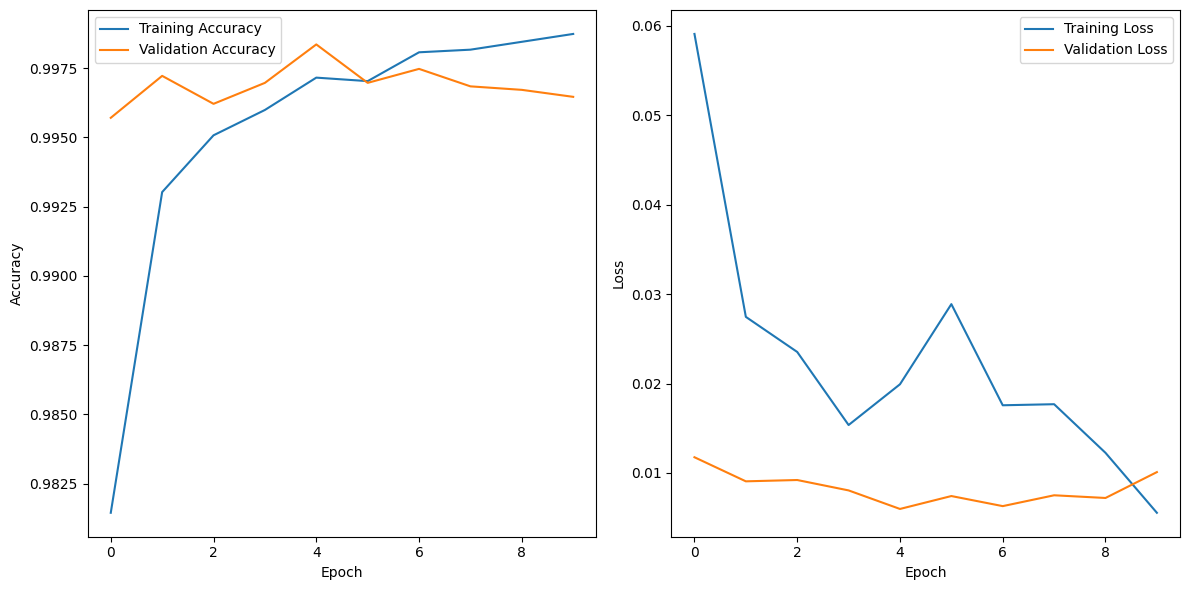

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Model Evaluation
test_results = model.evaluate([numerical_test_data, textual_test_data], y_test, verbose=1)

# Predictions for computing F1 score and AUC-ROC
y_pred = model.predict([numerical_test_data, textual_test_data]).ravel()
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary output

# Compute F1 score and AUC-ROC
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

310/310 [==============================] - 12s 34ms/step
F1 Score: 0.9673
ROC-AUC Score: 0.9999


#alyan stuff beloew

In [ ]:
views_95th_percentile = combined_data['view_count'].quantile(0.95)
combined_data['is_viral'] = (combined_data['view_count'] > views_95th_percentile).astype(int)

X = combined_data.drop(['is_viral'], axis=1)
y = combined_data['is_viral']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X['combined_text'])
max_sequence_length = max(len(x) for x in tokenizer.texts_to_sequences(X['combined_text']))
textual_train_data = pad_sequences(tokenizer.texts_to_sequences(X_train['combined_text']), maxlen=max_sequence_length)
textual_test_data = pad_sequences(tokenizer.texts_to_sequences(X_test['combined_text']), maxlen=max_sequence_length)

numerical_train_data = X_train[numerical_features].values
numerical_test_data = X_test[numerical_features].values

In [ ]:
# Model Definition
num_input = Input(shape=(numerical_train_data.shape[1],), name='num_input')
num_output = Dense(64, activation='relu')(num_input)
num_output = Dropout(0.5)(num_output)

text_input = Input(shape=(max_sequence_length,), name='text_input')
text_output = Embedding(input_dim=1000, output_dim=50, input_length=max_sequence_length)(text_input)
text_output = Bidirectional(LSTM(64))(text_output)
text_output = Dropout(0.5)(text_output)

merged = concatenate([num_output, text_output])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[num_input, text_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 872)]                0         []                            
                                                                                                  
 num_input (InputLayer)      [(None, 7)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 872, 50)              50000     ['text_input[0][0]']          
                                                                                                  
 dense (Dense)               (None, 64)                   512       ['num_input[0][0]']           
                                                                                              

In [ ]:
history = model.fit([numerical_train_data, textual_train_data], y_train, validation_split=0.2, epochs=1, batch_size=32)

10651/10651 [==============================] - 890s 82ms/step - loss: 0.0139 - accuracy: 0.9954 - precision: 0.9626 - recall: 0.9455 - val_loss: 0.0026 - val_accuracy: 0.9991 - val_precision: 0.9834 - val_recall: 0.9988


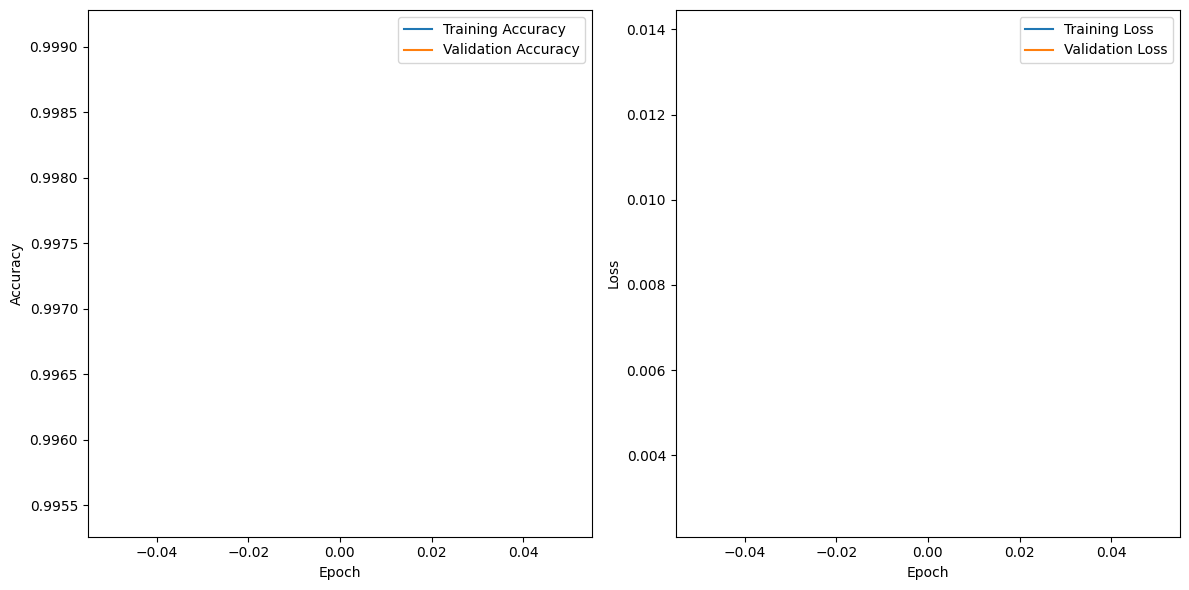

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Model Evaluation
test_results = model.evaluate([numerical_test_data, textual_test_data], y_test, verbose=1)

# Predictions for computing F1 score and AUC-ROC
y_pred = model.predict([numerical_test_data, textual_test_data]).ravel()
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary output

# Compute F1 score and AUC-ROC
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

3329/3329 [==============================] - 105s 31ms/step
F1 Score: 0.9902
ROC-AUC Score: 1.0000


In [ ]:
print(history.history)